In [1]:
import string
import re
import pickle
import random
from statistics import mean
from statistics import stdev
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import sqlite3
import prettytable
	
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight

import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [2]:
with open('../datafiles/pickles/affr_bow_500','rb') as affr_bow_500:
    affr_bow_500 = pickle.load(affr_bow_500).toarray()
    print(affr_bow_500.shape,affr_bow_500[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/affr_bigram_bow_500','rb') as affr_bigram_bow_500:
    affr_bigram_bow_500 = pickle.load(affr_bigram_bow_500).toarray()
    print(affr_bigram_bow_500.shape,affr_bigram_bow_500[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/affr_ngram_tfidf_500','rb') as affr_ngram_tfidf_500:
    affr_ngram_tfidf_500 = pickle.load(affr_ngram_tfidf_500).toarray()
    print(affr_ngram_tfidf_500.shape,affr_ngram_tfidf_500[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/avg_w2v','rb') as avg_w2v:
    avg_w2v = np.array(pickle.load(avg_w2v))
    print(avg_w2v.shape,avg_w2v[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/tdifd_weighted_w2v','rb') as tdifd_weighted_w2v:
    tdifd_weighted_w2v = np.array(pickle.load(tdifd_weighted_w2v))
    print(tdifd_weighted_w2v.shape,tdifd_weighted_w2v[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

w2v_model = gensim.models.Word2Vec.load("../datafiles/pickles/w2v_model.model")

(364171, 500) [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

In [3]:
w2v_model.wv.most_similar('like')

[('resemble', 0.7261250019073486),
 ('mean', 0.6467251181602478),
 ('dislike', 0.6167863607406616),
 ('prefer', 0.6120339632034302),
 ('think', 0.6117398738861084),
 ('overwhelm', 0.5994627475738525),
 ('overpower', 0.5890533924102783),
 ('bother', 0.5846970081329346),
 ('gross', 0.58452308177948),
 ('alright', 0.5642049908638)]

In [6]:
conn = sqlite3.connect('../datafiles/amazon_reviews.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score!=3""",conn)
def scr(s):
    if(s>3):
        return 1
    else:
        return 0
data['Score'] = data['Score'].apply(scr)
cus_data = data.drop_duplicates(subset={'UserId','ProfileName', 'Time', 'Text'},keep='first')
cus_data = cus_data[cus_data['HelpfulnessNumerator']<=cus_data['HelpfulnessDenominator']]
cus_data.reset_index(drop=True,inplace=True)
Scr = cus_data['Score'].copy()

In [7]:
df = pd.DataFrame(avg_w2v)
df['Y']  = cus_data['Score']
df.reset_index(drop=True)

#######################  BALANCING AN SECTION OF DATA ####################################
dataa = df.iloc[10000:15000].copy()
df_mino = dataa[dataa['Y']==0].copy()
df_majo = dataa[dataa['Y']==1].copy()
df_minority_upsampled = resample(df_mino,replace=True,n_samples=df_majo.shape[0],random_state=123)
df_upsampled = pd.concat([df_majo, df_minority_upsampled])

In [8]:
df_upsampled['Y'].value_counts()

1    4249
0    4249
Name: Y, dtype: int64

- We have to take the data leak into consideration, as if we first convert the text into vectors and then split into test and train then the test will kind off be built with the use of features of the train data. so to avoid such data leackage we need to spilt fist then vectorize the text.

In [198]:
class Knn:
    def __init__(self,X,Y,splits=5,algorithm='auto',balance=1,scale=0,istext=0,textPreprocessing='BOW'):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.splits = splits
        self.algorithm = algorithm
        self.scale = scale
        self.istext = istext
        self.textPreprocessing = textPreprocessing
        if(istext == 1 and (textPreprocessing =='BOW' or textPreprocessing =='TFIDF')):
            self.X = np.array(self.text_preprocessing1(self.X))
        elif(istext == 1 and (textPreprocessing =='AVG-W2V')):
            self.X = np.array(self.text_preprocessing2(self.X))
        elif(istext == 1 and (textPreprocessing =='TFIDF-W2V')):
            self.X = np.array(self.text_preprocessing3(self.X))
        if(balance == 1):
            self.Balance()
            
    def KNN_TS(self,hyper = list(range(1,100,2))):
        self.type = 0       
        self.X_train_n_cv, self.X_test, self.Y_train_n_cv, self.Y_test = train_test_split(self.X,self.Y,test_size=0.3,random_state=0)
        if(self.scale == 1):
            self.Scale()
        tscv = TimeSeriesSplit()
        TimeSeriesSplit(max_train_size=None, n_splits=self.splits)
        scrs = list()
        auroc_score = dict()
        self.roc_auc_stats = list()
        for n in tqdm(hyper):
            cv_fold_score = list()
            train_fold_score = list()
            auroc_fold_score = list()  # this score is from the cross-validation dataset
            auroc_fold_score_proba = list() # this is also from cv dataset
            auroc_fold_train = list() # this is from train dataset
            for train_index, cv_index in tscv.split(self.X_train_n_cv):
                X_train,Y_train = self.X_train_n_cv[train_index],self.Y_train_n_cv[train_index]
                X_cv,Y_cv = self.X_train_n_cv[cv_index],self.Y_train_n_cv[cv_index]
                model = KNeighborsClassifier(n_neighbors = n, algorithm = self.algorithm) 
                X_train,X_cv = self.vectorize(X_train,X_cv,self.textPreprocessing) 
                model.fit(X_train,Y_train)
                y_cv_pred_proba = model.predict_proba(X_cv)[:,1]
                y_cv_pred = model.predict(X_cv)
                cv_fold_score.append(model.score(X_cv,Y_cv))
                train_fold_score.append(model.score(X_train,Y_train))
                auroc_fold_score_proba.append(roc_auc_score(Y_cv,y_cv_pred_proba))
                auroc_fold_score.append(roc_auc_score(Y_cv,y_cv_pred))
                auroc_fold_train.append(roc_auc_score(Y_train,model.predict_proba(X_train)[:,1]))
            scrs.append([n,mean(cv_fold_score),mean(train_fold_score),mean(auroc_fold_score),mean(auroc_fold_score_proba)])
            auroc_score[n] = mean(auroc_fold_score_proba)
            self.roc_auc_stats.append([n,mean(auroc_fold_train),stdev(auroc_fold_train),mean(auroc_fold_score_proba),stdev(auroc_fold_score_proba)])
        max_roc_score = max(auroc_score.values())
        scrs = pd.DataFrame(data = scrs,columns=['K','CV score','Train score','AUROC','AUROC with probability'])
        optimal_k = max(auroc_score, key=auroc_score.get)
        self.scrs = scrs
        self.max_roc_score = max_roc_score
        self.optimal_k = optimal_k
        self.op_model = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = self.algorithm)
        self.X_train_n_cv,self.X_train_n_cv = self.vectorize(self.X_train_n_cv,self.X_train_n_cv,self.textPreprocessing)
        self.op_model.fit(self.X_train_n_cv,self.Y_train_n_cv)
        return self.op_model
                
    def KNN_KCV(self,hyper = list(range(1,100,10))):
        self.type = 1
        self.X = pd.DataFrame(self.X)
        self.Y = pd.DataFrame(self.Y)
        self.X_train_n_cv, self.X_test, self.Y_train_n_cv, self.Y_test = train_test_split(self.X,self.Y,test_size=0.25,random_state=0)
        if(self.scale == 1):
            self.Scale()
        indx = list(self.X_train_n_cv.index)
        random.shuffle(indx)
        split = [indx[i::self.splits] for i in range(self.splits)]
        scrs = list()
        auroc_score = dict()
        self.roc_auc_stats = list()
        for n in tqdm(hyper):
            cv_fold_score = list()
            train_fold_score = list()
            auroc_fold_score = list()
            auroc_fold_score_proba = list()
            auroc_fold_train = list()
            for j in range(1,self.splits+1):
                X_train  = self.X_train_n_cv.loc[list(set(self.X_train_n_cv.index)-set(split[j-1]))] 
                Y_train  = self.Y_train_n_cv.loc[list(set(self.X_train_n_cv.index)-set(split[j-1]))]
                X_cv  = self.X_train_n_cv.loc[split[j-1]]
                Y_cv  = self.Y_train_n_cv.loc[split[j-1]]
                model = KNeighborsClassifier(n_neighbors = n, algorithm = self.algorithm)
                X_train,X_cv = self.vectorize(X_train,X_cv,self.textPreprocessing)
                model.fit(X_train,Y_train)
                y_cv_pred_proba = model.predict_proba(X_cv)[:,1]
                y_cv_pred = model.predict(X_cv)
                cv_fold_score.append(model.score(X_cv,Y_cv))
                train_fold_score.append(model.score(X_train,Y_train))
                auroc_fold_score_proba.append(roc_auc_score(Y_cv,y_cv_pred_proba))
                auroc_fold_score.append(roc_auc_score(Y_cv,y_cv_pred))
                auroc_fold_train.append(roc_auc_score(Y_train,model.predict_proba(X_train)[:,1]))
            scrs.append([n,mean(cv_fold_score),mean(train_fold_score),mean(auroc_fold_score),mean(auroc_fold_score_proba)])
            auroc_score[n] = mean(auroc_fold_score_proba)
            self.roc_auc_stats.append([n,mean(auroc_fold_train),stdev(auroc_fold_train),mean(auroc_fold_score_proba),stdev(auroc_fold_score_proba)])
        max_roc_score = max(auroc_score.values())
        scrs = pd.DataFrame(data = scrs,columns=['K','CV score','Train score','AUROC','AUROC with probability'])
        optimal_k = max(auroc_score, key=auroc_score.get)
        self.max_roc_score = max_roc_score
        self.scrs = scrs
        self.optimal_k = optimal_k
        self.op_model = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = self.algorithm)
        self.X_train_n_cv,self.X_test = self.vectorize(self.X_train_n_cv,self.X_test,self.textPreprocessing)
        self.op_model.fit(self.X_train_n_cv,self.Y_train_n_cv)
        return self.op_model

    def recent_score(self):
        return self.op_model.score(self.X_test,self.Y_test)

    def Scale(self):
        sc = StandardScaler()
        if (self.type==1):
            self.X_train_n_cv = pd.DataFrame(sc.fit_transform(self.X_train_n_cv),index=self.X_train_n_cv.index)
            self.X_test = pd.DataFrame(sc.transform(self.X_test),index=self.X_test.index)
        else:
            self.X_train_n_cv = sc.fit_transform(self.X_train_n_cv)
            self.X_test = sc.transform(self.X_test)


    def Plot_roc(self):
        y_probability = self.op_model.predict_proba(self.X_test)
        fpr, tpr, threshold = roc_curve(self.Y_test, y_probability[:,1])
        roc_auc = roc_auc_score(self.Y_test, y_probability[:,1])
        plt.title('Receiver Operating Characteristic Test data')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title('ROC Curve of kNN')
        plt.show()

    def Plot_CV_roc_score(self):
        rocstats = np.array(self.roc_auc_stats)
        sns.set_style("darkgrid")
        sns.set_palette(sns.color_palette("Dark2", 2))
        sns.lineplot(y=rocstats[:,1],x=rocstats[:,0],label = "Train AUROC")
        sns.lineplot(y=rocstats[:,3],x=rocstats[:,0],label = "CV AUROC")  
        plt.fill_between(x=rocstats[:,0],y1=rocstats[:,3]+rocstats[:,4],y2=rocstats[:,3]-rocstats[:,4],color="#ffd1b3")
        plt.fill_between(x=rocstats[:,0],y1=rocstats[:,1]+rocstats[:,2],y2=rocstats[:,1]-rocstats[:,2],color="#B4EEB4")
        plt.title("ROC score of Train and CV data set with it's spanning standard deviation")
        plt.ylabel('ROC score')
        plt.xlabel('K as hyperparameter')       

    def Plot_CV_scrs(self):
        trn_err = self.scrs['Train score'].apply(lambda x: 1-x,1)
        cv_err = self.scrs['CV score'].apply(lambda x: 1-x,1)
        sns.lineplot(y='CV score',x='K',data=self.scrs)
        sns.lineplot(y='Train score',x='K',data=self.scrs)
        fig = plt.figure()
        sns.lineplot(y=cv_err,x='K',data=self.scrs)
        sns.lineplot(y=trn_err,x='K',data=self.scrs)

    def Confusion_mat(self):
        plot_confusion_matrix(self.op_model, self.X_train_n_cv, self.Y_train_n_cv)
        plot_confusion_matrix(self.op_model, self.X_test, self.Y_test)
        plt.show()

    def Balance(self):
        ubal_data = pd.DataFrame(self.X)
        ubal_data['Y'] = self.Y
        ubal_mino = ubal_data[ubal_data['Y']==0].copy()
        ubal_majo = ubal_data[ubal_data['Y']==1].copy()
        ubal_mino_balanced = resample(ubal_mino,replace=True,n_samples=ubal_majo.shape[0],random_state=123)
        ubal_balanced = pd.concat([ubal_majo, ubal_mino_balanced])
        self.X = np.array(ubal_balanced.iloc[:,:-1])
        self.Y = np.array(ubal_balanced['Y'])
        return ubal_balanced
    
    def cln_html(self,sen):
        clnd = re.sub(r'<.*?>',r' ',sen)
        return clnd
    def cln_punc(self,sen):
        clnd = re.sub(r'[?|!|\'|"|#]',r'',sen)
        clnd = re.sub(r'[.|,|)|(|\|/]',r' ',clnd)
        return clnd   
    def text_preprocessing1(self,textdata):
        stop = set(stopwords.words('english'))
        sno = nltk.stem.SnowballStemmer('english') 
        i=0
        str1=' '
        final_string=[]
        s=''
        for sent in textdata:
            filtered_sentence=[]
            sent=self.cln_html(sent)
            for w in sent.split():
                for cleaned_words in self.cln_punc(w).split():
                    if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                        if(cleaned_words.lower() not in stop):
                            s=(sno.stem(cleaned_words.lower())).encode('utf8')
                            filtered_sentence.append(s)
                        else:
                            continue
                    else:
                        continue 
            str1 = b" ".join(filtered_sentence)
            final_string.append(str1)
            i+=1
        return final_string
    def text_preprocessing2(self,textdata):
        list_of_sent=[]
        for sent in textdata:
            filtered_sentence=[]
            sent=self.cln_html(sent)
            for w in sent.split():
                for cleaned_words in self.cln_punc(w).split():
                    if(cleaned_words.isalpha()):    
                        filtered_sentence.append(cleaned_words.lower())
                    else:
                        continue
            list_of_sent.append(filtered_sentence)
        return list_of_sent
    def text_preprocessing3(self,textdata):
        text1 = self.text_preprocessing1(textdata)
        text2 = self.text_preprocessing2(textdata)
        x = pd.DataFrame({'BOW':text1,'TFIDF':text2})
        return x.to_numpy()
    def vectorize(self,traindata,testdata,kind):
        if(self.istext==1): 
            traindata = pd.DataFrame(traindata)
            testdata = pd.DataFrame(testdata)      
            if(kind=='BOW'):
                bow = CountVectorizer(ngram_range=(1,2),max_features=500)
                train_bow = bow.fit_transform(pd.Series(traindata.iloc[:,0]))
                test_bow = bow.transform(pd.Series(testdata.iloc[:,0]))
                return train_bow,test_bow
            ##############################################################################
            elif(kind=='TFIDF'):
                tf_idf=TfidfVectorizer(ngram_range=(1,2),max_features=500)
                train_tdidf=tf_idf.fit_transform(pd.Series(traindata.iloc[:,0]))
                test_tdidf=tf_idf.transform(pd.Series(testdata.iloc[:,0]))
                return train_tdidf,test_tdidf
            ##############################################################################
            elif(kind=='AVG-W2V'):
                w2v_model=gensim.models.Word2Vec(pd.Series(traindata.iloc[:,0]),min_count=5,size=50, workers=4)
                i=0
                train_vectors = []; 
                for sent in pd.Series(traindata.iloc[:,0]):
                    sent_vec = np.zeros(50) 
                    cnt_words =0; 
                    for word in sent: 
                        try:
                            vec = w2v_model.wv[word]
                            sent_vec += vec
                            cnt_words += 1
                            i=i+1
                        except:
                            pass
                    sent_vec /= cnt_words
                    train_vectors.append(sent_vec)
                i=0
                test_vectors = []; 
                for sent in pd.Series(testdata.iloc[:,0]):
                    sent_vec = np.zeros(50) 
                    cnt_words =0; 
                    for word in sent: 
                        try:
                            vec = w2v_model.wv[word]
                            sent_vec += vec
                            cnt_words += 1
                            i=i+1
                        except:
                            pass
                    sent_vec /= cnt_words
                    test_vectors.append(sent_vec)
                return train_vectors,test_vectors   
            ##############################################################################       
            elif(kind=='TFIDF-W2V'):
                w2v_model=gensim.models.Word2Vec(pd.Series(traindata.iloc[:,1]),min_count=5,size=50, workers=4)
                tf_idf=TfidfVectorizer(max_features=500)
                tf_idf_vec = tf_idf.fit_transform(pd.Series(traindata.iloc[:,0]))
                tfidf_feat = tf_idf.get_feature_names() 
                tf_idf_vec2 = tf_idf.transform(pd.Series(testdata.iloc[:,0]))
                train_vectors = []
                row=0
                for sent in pd.Series(traindata.iloc[:,1]):
                    sent_vec = np.zeros(50) 
                    weight_sum =0 
                    for word in sent:
                        try:
                            vec = w2v_model.wv[word]
                            tfidf = tf_idf_vec[row, tfidf_feat.index(word)]
                            sent_vec += (vec * tfidf)
                            weight_sum += tfidf
                        except:
                            pass
                    sent_vec /= weight_sum
                    train_vectors.append(sent_vec)
                    row += 1
                train_df=pd.DataFrame(train_vectors)
                train_df.fillna(train_df.mean(),inplace=True)

                test_vectors = []
                row=0
                for sent in pd.Series(testdata.iloc[:,1]):
                    sent_vec = np.zeros(50) 
                    weight_sum =0 
                    for word in sent:
                        try:
                            vec = w2v_model.wv[word]
                            tfidf = tf_idf_vec2[row, tfidf_feat.index(word)]
                            sent_vec += (vec * tfidf)
                            weight_sum += tfidf
                        except:
                            pass
                    sent_vec /= weight_sum
                    test_vectors.append(sent_vec)
                    row += 1
                test_df=pd.DataFrame(test_vectors)
                test_df.fillna(test_df.mean(),inplace=True)
                # test_df.dropna(inplace=True)
                # print(test_df.shape)
                return train_df,test_df  
            
            else:
                return traindata,testdata
        else:
            return traindata,testdata



In [199]:
knn = Knn(cus_data.iloc[23000:25000,9],cus_data.iloc[23000:25000,6],balance=1,scale=0,istext=1,textPreprocessing='TFIDF-W2V')
# knn = Knn(cus_data.iloc[22000:25000,9],cus_data.iloc[22000:25000,6],balance=1,scale=0)

In [204]:
knn.KNN_KCV(hyper=list(range(1,100,10)))

100%|██████████| 10/10 [04:04<00:00, 24.46s/it]


KNeighborsClassifier(n_neighbors=1)

In [201]:
knn.recent_score()

0.8763505402160864

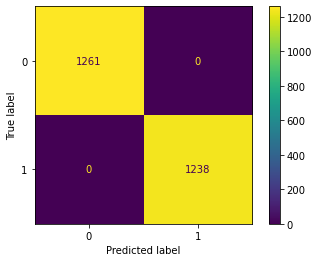

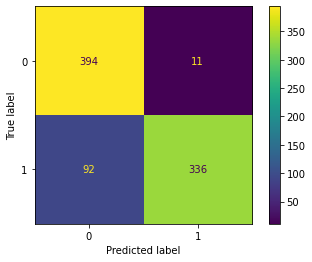

In [202]:
knn.Confusion_mat()

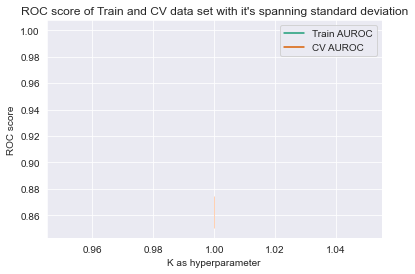

In [203]:
knn.Plot_CV_roc_score()

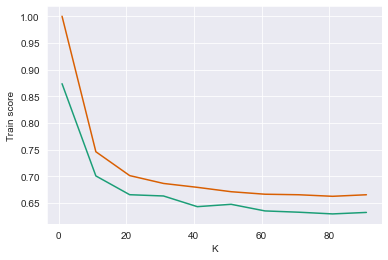

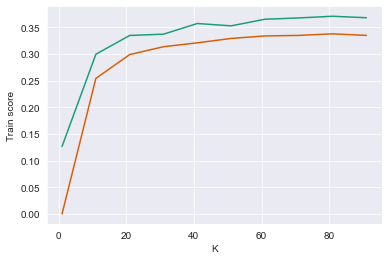

In [41]:
knn.Plot_CV_scrs()

In [136]:
pd.DataFrame(bow.toarray())

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364167,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
364168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
tet = knn.Balance()

In [31]:
knn.KNN_TS()

100%|██████████| 33/33 [08:15<00:00, 15.02s/it]


KNeighborsClassifier(n_neighbors=4)

In [38]:
knn.op_model.score(knn.X_test,knn.Y_test)

0.8454901960784313

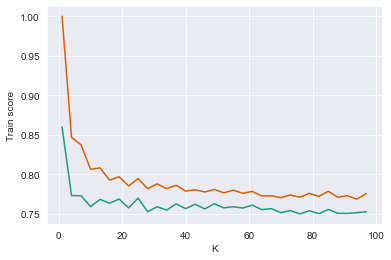

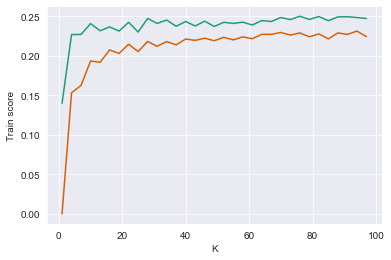

In [39]:
knn.Plot_CV_scrs()

In [137]:
# knn = Knn(tdifd_weighted_w2v,Scr[0:1000])
knn = Knn(avg_w2v[11000:12000],Scr[11000:12000])

- ### Trying out diff. folds in kfold-cv.

In [138]:
 omodel = knn.KNN_KCV()

100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


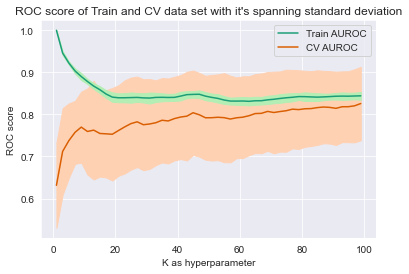

In [144]:
knn.Plot_CV_roc_score()

In [16]:
scores,auc,ok = knn.KNN_KCV(5)

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


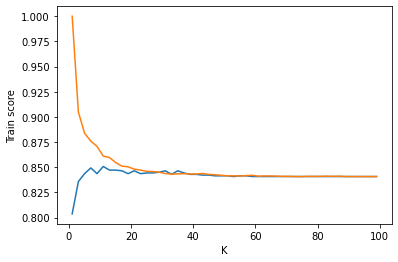

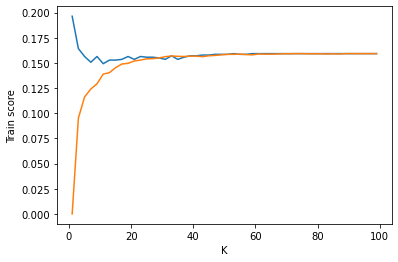

In [17]:
knn.Plot_scrs()

In [18]:
scores,auc,ok = knn.KNN_KCV(20)

100%|██████████| 50/50 [03:55<00:00,  4.72s/it]


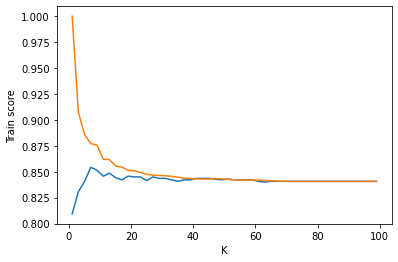

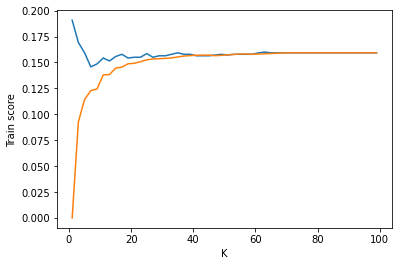

In [20]:
knn.Plot_scrs()

- Here we are doing gridsearch on Knn with the balanced data set (this was befor when we added the Balance() function in our KNN class) 

In [42]:
x1,x2,y1,y2 = train_test_split(df_upsampled.iloc[:,:50],df_upsampled.iloc[:,50],test_size=0.3,random_state=0)
clf = GridSearchCV(estimator=KNeighborsClassifier(),param_grid={'n_neighbors':list(range(1,100,3))},cv=10)
clf.fit(x1,y1)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28,
                                         31, 34, 37, 40, 43, 46, 49, 52, 55, 58,
                                         61, 64, 67, 70, 73, 76, 79, 82, 85, 88, ...]})

In [43]:
clf.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [47]:
clf.cv_results_;

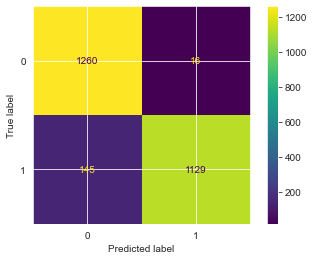

In [45]:
plot_confusion_matrix(clf.best_estimator_,x2,y2)

In [160]:
compute_class_weight(class_weight = 'balanced',classes=[0,1],y=Scr[11000:12000])

array([3.28947368, 0.58962264])

- ### This is testing different accuracies for different datasets(diff. portions of datasets) and diff. 'n' in knn. 

In [34]:
for i in tqdm([1,10**1,10**2,10**3]):
    cvscr = cross_val_score(KNeighborsClassifier(i),avg_w2v[10000:20000],Scr[10000:20000],cv=5)
    print(cvscr.mean())

100%|██████████| 4/4 [00:37<00:00,  9.26s/it]0.8428000000000001



In [35]:
k_lst = range(1,1000,100)
for i in tqdm(k_lst):
    cvscr = cross_val_score(KNeighborsClassifier(i),avg_w2v[10000:20000],Scr[10000:20000],cv=5)
    print(cvscr.mean())

100%|██████████| 10/10 [02:05<00:00, 12.50s/it]0.8428000000000001



In [36]:
for i in tqdm([1,10**1,10**2,10**3]):
    cvscr = cross_val_score(KNeighborsClassifier(i),affr_bow_500[10000:15000],Scr[10000:15000],cv=5)
    print(cvscr.mean())

100%|██████████| 4/4 [03:56<00:00, 59.13s/it]0.8497999999999999



In [41]:
k_lst = range(1,400,50)
for i in tqdm(k_lst):
    cvscr = cross_val_score(KNeighborsClassifier(i),avg_w2v[10000:13000],Scr[10000:13000],cv=5)
    print(cvscr.mean())

100%|██████████| 8/8 [00:26<00:00,  3.31s/it]0.8400000000000001



In [42]:
for i in tqdm([1,10**1,10**2,10**3]):
    cvscr = cross_val_score(KNeighborsClassifier(i),affr_ngram_tfidf_500[10000:20000],Scr[10000:20000],cv=5)
    print(cvscr.mean())

100%|██████████| 4/4 [16:33<00:00, 248.47s/it]0.8428000000000001



In [43]:
k_lst = range(1,400,50)
for i in tqdm(k_lst):
    cvscr = cross_val_score(KNeighborsClassifier(i),affr_ngram_tfidf_500[10000:13000],Scr[10000:13000],cv=5)
    print(cvscr.mean())

100%|██████████| 8/8 [03:01<00:00, 22.67s/it]0.8400000000000001



- ### Implementing knn for the data set by keril e.

In [265]:
kdata= pd.read_csv('../datafiles/knn_keril.csv')
kdata['Purchased'].value_counts()

0    257
1    143
Name: Purchased, dtype: int64

In [268]:
kknn = Knn(kdata.iloc[:,:2],kdata.iloc[:,2],balance=0,scale=1)

In [269]:
kknn.KNN_KCV()

100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


KNeighborsClassifier(n_neighbors=21)

In [270]:
kknn.recent_score()

0.93

In [98]:
kknn.KNN_TS(hyper=list(range(1,50)),balance=0,scale=1)

100%|██████████| 49/49 [00:03<00:00, 16.28it/s]


KNeighborsClassifier(n_neighbors=21)

In [99]:
kknn.recent_score()

0.9166666666666666

> This analysis si from the kknn.KNN_KCV model

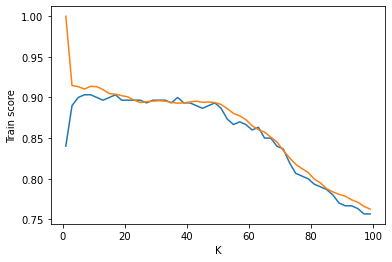

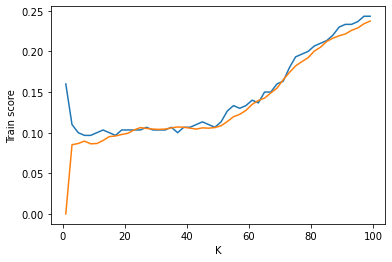

In [105]:
kknn.Plot_CV_scrs()

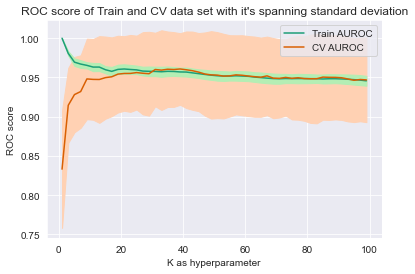

In [107]:
kknn.Plot_CV_roc_score()

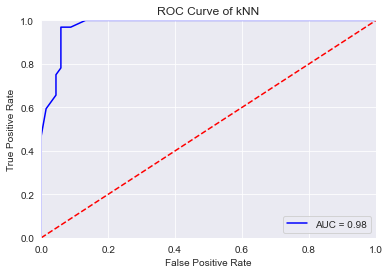

In [108]:
kknn.Plot_roc()

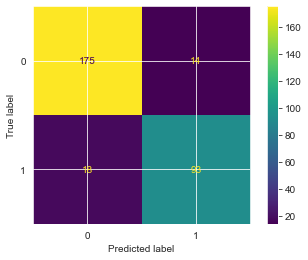

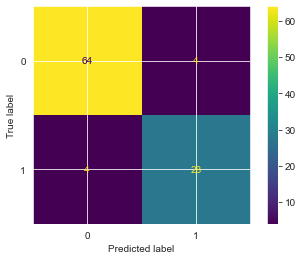

In [109]:
kknn.Confusion_mat()